In [1]:
import PID
import time
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import make_interp_spline
%matplotlib inline

## define PID weights

PID controller minimizes error by adjusting a control variable (eg power supplied) to a new value determined by a weighted sum of present (P), past (I), and future (D) error values.

In [2]:
P = 1.6 # weight current errors more
I = 4
D = 0.000000001 # ignore future potential errors 

In [3]:
L = 50 # number of iterations

In [4]:
pid = PID.PID(1.00, 1.00, 1.83)

pid.SetPoint=0.0
pid.setSampleTime(0.01)

END = L
feedback = 0

feedback_list = []
time_list = []
setpoint_list = []

p_term_list = []
i_term_list = []
d_term_list = []

for i in range(1, END):
    pid.update(feedback)
    
    p_term_list.append(pid.PTerm)
    i_term_list.append(pid.ITerm)
    d_term_list.append(pid.DTerm)
    
    output = pid.output
    if pid.SetPoint > 0:
        feedback += (output - (1/i))
    if i>9:
        pid.SetPoint = 1
    time.sleep(0.02)

    feedback_list.append(feedback)
    setpoint_list.append(pid.SetPoint)
    time_list.append(i)

time_sm = np.array(time_list)
time_smooth = np.linspace(time_sm.min(), time_sm.max(), 300) 
feedback_smooth = make_interp_spline(time_list, feedback_list)(time_smooth)

## how quickly does it converge?

green is desired value; blue is actual

(0.5, 1.5)

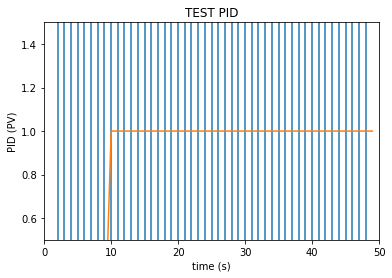

In [5]:
plt.plot(time_smooth, feedback_smooth)
plt.plot(time_list, setpoint_list)
plt.xlim((0, L))
plt.ylim((min(feedback_list)-0.5, max(feedback_list)+0.5))
plt.xlabel('time (s)')
plt.ylabel('PID (PV)')
plt.title('TEST PID')

plt.ylim((1-0.5, 1+0.5))

## 가설 1 : PTerm, ITerm, DTerm의 변화가 크지 않다?

각 Term의 차이가 크지 않다면(차이가 거의 없다면), 한번 trial한 데이터로 최적의 P, I, D값을 뽑을 수 있지 않을까?

In [ ]:
cases = [(1.5,5,0),(1.3,3,0.001),(1.2,2,0.0001)]

In [ ]:
plt.figure(figsize=(10,15))
plt.xlabel('time (s)')

ax_pid = plt.subplot(4,1,1)
ax_p = plt.subplot(4,1,2)
ax_i = plt.subplot(4,1,3)
ax_d = plt.subplot(4,1,4)

ax_pid.set_title('PID output')
ax_p.set_title('PTerm')
ax_i.set_title('ITerm')
ax_d.set_title('DTerm')

# SetPoint Plot Setting
ax_pid.plot(time_list, setpoint_list)


for case in cases:
    pid = PID.PID(*case)

    pid.SetPoint=0.0
    pid.setSampleTime(0.01)

    END = L
    feedback = 0

    feedback_list = []
    time_list = []
    setpoint_list = []

    p_term_list = []
    i_term_list = []
    d_term_list = []

    for i in range(1, END):
        pid.update(feedback)

        p_term_list.append(pid.PTerm)
        i_term_list.append(pid.ITerm)
        d_term_list.append(pid.DTerm)

        output = pid.output
        if pid.SetPoint > 0:
            feedback += (output - (1/i))
        if i>9:
            pid.SetPoint = 1
        time.sleep(0.02)

        feedback_list.append(feedback)
        setpoint_list.append(pid.SetPoint)
        time_list.append(i)

    time_sm = np.array(time_list)
    time_smooth = np.linspace(time_sm.min(), time_sm.max(), 300) 
    feedback_smooth = make_interp_spline(time_list, feedback_list)(time_smooth)
    
    ax_pid.plot(time_smooth, feedback_smooth, label=f'{case}')
    ax_pid.legend()
    
    ax_p.plot(time_list, p_term_list, label=f'{case}')
    ax_p.legend()
    
    ax_i.plot(time_list, i_term_list, label=f'{case}')
    ax_i.legend()
    
    ax_d.plot(time_list, d_term_list, label=f'{case}')
    ax_d.legend()
    
    
plt.show()

차이가 많이 난다.

## 가설2 : PID 제어 도중에 p, i, d값을 업데이트하면 어떻게 될까?

In [ ]:
P = np.array([0 + p*0.02 for p in range(100)]) # weight current errors more
I = np.array([0 + i*0.02 for i in range(100)])
D = np.array([0.0000005 + d*0.00000001 for d in range(100)]) # ignore future potential errors 
L = 100 # number of iterations

pid = PID.PID()

pid.SetPoint=0.0
pid.setSampleTime(0.01)

END = L
feedback = 0

feedback_list = []
time_list = []
setpoint_list = []

for i in range(1, END):
    
    '''
    강화학습 알고리즘이 들어올 곳
    '''
    pid.Kp = P[i]
    pid.Ki = I[i]
    pid.Kd = D[i]
    

    pid.update(feedback)
    setpoint_list.append(pid.SetPoint)
    
    output = pid.output
#     if pid.SetPoint = 0:
    feedback += output
    if 9<i<50:
        pid.SetPoint = 1
    elif 50<i<90:
        pid.SetPoint = -1
    else:
        pid.SetPoint = 0
        
    time.sleep(0.03)

    feedback_list.append(feedback)
    time_list.append(i)    

plt.plot(time_list, feedback_list)
plt.plot(time_list, setpoint_list)
plt.xlim((0, L))
plt.ylim((min(feedback_list)-0.5, max(feedback_list)+0.5))
plt.xlabel('time (s)')
plt.ylabel('PID (PV)')
plt.title('TEST PID')

plt.ylim((-1-0.5, 1+0.5))

## 가설3 : PID제어 도중 PID-tunning RL 도입

In [6]:
# QAC
import sys
import numpy as np
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
import tensorflow as tf
import numpy as np

### A2C가 제대로 학습되는지 확인 - CartPole

In [ ]:
# class A2CAgent:
#     def __init__(self, state_size, action_size):
#         self.render = False
#         self.load_model = False
#         # 상태와 행동의 크기 정의
#         self.state_size = state_size
#         self.action_size = action_size
#         self.value_size = 1
#         self.update_bound = 10

#         # 액터-크리틱 하이퍼파라미터
#         self.discount_factor = 0.99
#         self.actor_lr = 0.001
#         self.critic_lr = 0.005

#         # 정책신경망과 가치신경망 생성
#         self.actor = self.build_actor()
#         self.critic = self.build_critic()
#         self.actor_optimizer = tf.keras.optimizers.Adam()
#         self.critic_optimizer = tf.keras.optimizers.Adam()

#         if self.load_model:
#             self.actor.load_weights("./save_model/actor_trained.h5")
#             self.critic.load_weights("./save_model/critic_trained.h5")

#     # actor: 상태를 받아 각 행동의 확률을 계산
#     def build_actor(self):
#         actor = Sequential()
#         actor.add(Dense(24, input_dim=self.state_size, activation='relu',
#                         kernel_initializer='he_uniform'))
#         actor.add(Dense(self.action_size, activation='softmax',
#                         kernel_initializer='he_uniform'))
#         return actor

#     # critic: 상태를 받아서 상태의 가치를 계산
#     def build_critic(self):
#         critic = Sequential()
#         critic.add(Dense(24, input_dim=self.state_size, activation='relu',
#                          kernel_initializer='he_uniform'))
#         critic.add(Dense(24, input_dim=self.state_size, activation='relu',
#                          kernel_initializer='he_uniform'))
#         critic.add(Dense(self.value_size, activation='linear',
#                          kernel_initializer='he_uniform'))
#         return critic
    
#     def get_action(self, state):
#         policy = self.actor.predict(state, batch_size=1).flatten()
#         return np.random.choice(self.action_size, 1, p=policy)[0]

#     # 정책신경망을 업데이트하는 함수
#     def train_actor(self, action, state, advantage):
#         with tf.GradientTape() as t:
#             output = self.actor(state)
#             output_prob = K.sum(action * output, axis=1)
#             loss = -K.sum(K.log(output_prob) * advantage)
#         g_theta = t.gradient(loss, self.actor.trainable_weights)
#         grads = zip(g_theta, self.actor.trainable_weights)
#         self.actor_optimizer.apply_gradients(grads)

#     # 가치신경망을 업데이트하는 함수
#     def train_critic(self, state, target):
#         with tf.GradientTape() as t:
#             output = self.critic(state)
#             loss = K.mean(K.square(target - output))
#         g_omega = t.gradient(loss, self.critic.trainable_weights)
#         grads = zip(g_omega, self.critic.trainable_weights)
#         self.critic_optimizer.apply_gradients(grads)

#     # 각 타임스텝마다 정책신경망과 가치신경망을 업데이트
#     def train_model(self, state, action, reward, next_state, done):
#         value = self.critic(state)[0]
#         next_value = self.critic(next_state)[0]
        
#         act = np.zeros([1, self.action_size])
#         act[0][action] = 1

#         # 벨만 기대 방정식를 이용한 어드벤티지와 업데이트 타깃
#         advantage = reward - value + (1 - done)*(self.discount_factor * next_value)
#         target = reward + (1 - done)*(self.discount_factor * next_value)
        
#         self.train_actor(act, state, advantage)
#         self.train_critic(state, target)

In [ ]:
# import gym

# if __name__ == "__main__":
#     # CartPole-v1 환경, 최대 타임스텝 수가 500
#     env = gym.make('CartPole-v1')
#     # 환경으로부터 상태와 행동의 크기를 받아옴
#     state_size = env.observation_space.shape[0]
#     action_size = env.action_space.n

#     # 액터-크리틱(A2C) 에이전트 생성
#     agent = A2CAgent(state_size, action_size)

#     scores, episodes = [], []

#     for e in range(400):
#         done = False
#         score = 0
#         state = env.reset()
#         state = np.reshape(state, [1, state_size])

#         while not done:
#             if agent.render:
#                 env.render()

#             action = agent.get_action(state)
#             next_state, reward, done, info = env.step(action)
#             next_state = np.reshape(next_state, [1, state_size])
#             # 에피소드가 중간에 끝나면 -100 보상
#             reward = reward if not done or score == 499 else -100

#             agent.train_model(state, action, reward, next_state, done)

#             score += reward
#             state = next_state

#             if done:
#                 # 에피소드마다 학습 결과 출력
#                 score = score if score == 500.0 else score + 100
#                 scores.append(score)
#                 episodes.append(e)
#                 plt.plot(episodes, scores, 'b')
#                 plt.savefig("./save_graph/cartpole_a2c.png")
#                 print("episode:", e, "  score:", score)

#                 # 이전 10개 에피소드의 점수 평균이 490보다 크면 학습 중단# import gym

# if __name__ == "__main__":
#     # CartPole-v1 환경, 최대 타임스텝 수가 500
#     env = gym.make('CartPole-v1')
#     # 환경으로부터 상태와 행동의 크기를 받아옴
#     state_size = env.observation_space.shape[0]
#     action_size = env.action_space.n

#     # 액터-크리틱(A2C) 에이전트 생성
#     agent = A2CAgent(state_size, action_size)

#     scores, episodes = [], []

#     for e in range(400):
#         done = False
#         score = 0
#         state = env.reset()
#         state = np.reshape(state, [1, state_size])

#         while not done:
#             if agent.render:
#                 env.render()

#             action = agent.get_action(state)
#             next_state, reward, done, info = env.step(action)
#             next_state = np.reshape(next_state, [1, state_size])
#             # 에피소드가 중간에 끝나면 -100 보상
#             reward = reward if not done or score == 499 else -100

#             agent.train_model(state, action, reward, next_state, done)

#             score += reward
#             state = next_state

#             if done:
#                 # 에피소드마다 학습 결과 출력
#                 score = score if score == 500.0 else score + 100
#                 scores.append(score)
#                 episodes.append(e)
#                 plt.plot(episodes, scores, 'b')
#                 plt.savefig("./save_graph/cartpole_a2c.png")
#                 print("episode:", e, "  score:", score)

#                 # 이전 10개 에피소드의 점수 평균이 490보다 크면 학습 중단
#                 if np.mean(scores[-min(10, len(scores)):]) > 490:
# #                     agent.actor.save_weights("./save_model/cartpole_actor.h5")
# #                     agent.critic.save_weights(
# #                         "./save_model/cartpole_critic.h5")
#                     sys.exit()

#     env.close()
#                 if np.mean(scores[-min(10, len(scores)):]) > 490:
# #                     agent.actor.save_weights("./save_model/cartpole_actor.h5")
# #                     agent.critic.save_weights(
# #                         "./save_model/cartpole_critic.h5")
#                     sys.exit()

#     env.close()

A2C학습이 잘 되는 것 확인

### PID Tunning을 위한 A2C 구현

In [170]:
class A2CPIDTunner:
    def __init__(self, state_size, action_size, load_model=False):
        self.load_model = load_model
        # 상태와 행동의 크기 정의
        self.state_size = state_size
        self.action_size = action_size
        self.value_size = 1
        self.grad_bound = 0.
        
        self.std_bound = [1e-2, 1.0]

        # 액터-크리틱 하이퍼파라미터
        self.discount_factor = 0.99
        self.actor_lr = 0.001
        self.critic_lr = 0.005

        # 정책신경망과 가치신경망 생성
        self.actor = self.build_actor()
        self.critic = self.build_critic()
        self.actor_optimizer = tf.keras.optimizers.Adam()
        self.critic_optimizer = tf.keras.optimizers.Adam()

        if self.load_model:
            self.actor.load_weights("./save_model/actor_trained.h5")
            self.critic.load_weights("./save_model/critic_trained.h5")

    # actor: 상태를 받아 각 행동의 확률을 계산
    def build_actor(self):
        input_state = tf.keras.Input((self.state_size,))
        d1 = tf.keras.layers.Dense(24, activation='relu')(input_state)
        out_mu = tf.keras.layers.Dense(self.action_size, activation='tanh')(d1)
        out_std = tf.keras.layers.Dense(self.action_size, activation='softplus')(d1)
        actor =  tf.keras.Model(input_state, [out_mu, out_std])
        return actor

    # critic: 상태를 받아서 상태의 가치를 계산
    def build_critic(self):
        input_state = tf.keras.Input((self.state_size,))
        d1 = tf.keras.layers.Dense(24, activation='relu')(input_state)
        d2 = tf.keras.layers.Dense(24, activation='relu')(d1)
        output = tf.keras.layers.Dense(1, activation='tanh')(d2)
        critic = tf.keras.Model(input_state, output)
        return critic

    # log_policy pdf
    def log_pdf(self, mu, std, action):
        std = tf.clip_by_value(std, self.std_bound[0], self.std_bound[1])
        var = std**2
        log_policy_pdf = -0.5 * (action - mu) ** 2 / var - 0.5 * tf.math.log(var * 2 * np.pi)
        return tf.reduce_sum(log_policy_pdf, 1, keepdims=True)
    
    # 정책신경망의 출력을 받아 확률적으로 행동을 선택
    def get_action(self, state):
        mu, std = self.actor(np.reshape(state, [1, self.state_size]))
        mu = mu[0]
        std = std[0]

        std = tf.clip_by_value(std, self.std_bound[0], self.std_bound[1])
        action = np.random.normal(mu, std, size=self.action_size)
        return action

    # 정책신경망을 업데이트하는 함수
    def train_actor(self, action, state, advantage):
        with tf.GradientTape() as t:
            mu_a, std_a = self.actor(state)
            log_policy_pdf = self.log_pdf(mu_a, std_a, action)
            loss = -K.sum(log_policy_pdf * advantage)
        g_theta = t.gradient(loss, self.actor.trainable_weights)
        grads = zip(g_theta, self.actor.trainable_weights)
        grads = [(tf.clip_by_value(grad, -self.grad_bound, self.grad_bound), var) for grad, var in grads]
        self.actor_optimizer.apply_gradients(grads)

    # 가치신경망을 업데이트하는 함수
    def train_critic(self, state, target):
        with tf.GradientTape() as t:
            output = self.critic(state)
            loss = K.mean(K.square(target - output))
        g_omega = t.gradient(loss, self.critic.trainable_weights)
        grads = zip(g_omega, self.critic.trainable_weights)
        grads = [(tf.clip_by_value(grad, -self.grad_bound, self.grad_bound), var) for grad, var in grads]
        self.critic_optimizer.apply_gradients(grads)

    # 각 타임스텝마다 정책신경망과 가치신경망을 업데이트
    def train_model(self, state, action, reward, next_state, done):
        value = self.critic(state)[0]
        next_value = self.critic(next_state)[0]

        # 벨만 기대 방정식를 이용한 어드벤티지와 업데이트 타깃
        advantage = reward - value + (1 - done)*(self.discount_factor * next_value)
        target = reward + (1 - done)*(self.discount_factor * next_value)
        
        self.train_actor(action, state, advantage)
        self.train_critic(state, target)

### Sample 환경 구성

In [171]:
class PIDsampleEnv(PID.PID):
    
    def __init__(self, P=0.2, I=0.0, D=0.0, set_point=1):
        super().__init__(self)
        
        self.Kp = P
        self.Ki = I
        self.Kd = D
    
        self.set_point = set_point
        self.end = 80
        
    def reset(self):
        self.clear()
        return np.zeros(self.end)
    
    def step(self, action):
        
        max_error = 0
        feedback = 0
        done = False
        
        self.Kp = action[0]
        self.Ki = action[1]
        self.Kd = action[2]
        
        next_state = []
        
        for i in range(1, self.end+1):
            self.update(feedback)
            output = self.output
            
            if self.SetPoint > 0:
                feedback = output
                next_state.append(feedback)
            if 10<=i<60:
                self.SetPoint = self.set_point
            else:
                self.SetPoint = 0
            
            error = self.last_error
            if abs(error) > max_error:
                max_error = abs(error)
            
        if max_error < (self.SetPoint)*0.1:
            done = True
        
        return next_state, -max_error, done
    
    def plot(self):
        
        feedback = 0.0

        feedback_list = []
        time_list = []
        setpoint_list = []

        for i in range(1, self.end+1):
            
            self.update(feedback)
            output = self.output
            
            setpoint_list.append(self.SetPoint)

            if self.SetPoint > 0:
                feedback += output
            
            if 10<=i<60:
                self.SetPoint = self.set_point
            else:
                self.SetPoint = 0.0
            
            feedback_list.append(feedback)    
            time_list.append(i)

        plt.plot(time_list, feedback_list)
        plt.plot(time_list, setpoint_list)
        plt.xlim((0, L))
        plt.ylim((min(feedback_list)-0.5, max(feedback_list)+0.5))
        plt.xlabel('time (s)')
        plt.ylabel('PID (PV)')
        plt.title('TEST PID')

        plt.ylim((0-0.5, 1+0.5))

In [ ]:
env = PIDsampleEnv(set_point=1)

state_size = 80
action_size = 3

# 액터-크리틱(A2C) 에이전트 생성
agent = A2CPIDTunner(state_size, action_size, load_model=False)

scores, episodes = [], []


for e in range(400):
    done = False
    state = env.reset()
    state = np.reshape(state, [1, state_size])

    while not done:

        action = agent.get_action(state)
        next_state, reward, done = env.step(action)
        next_state = np.reshape(next_state, [1, state_size])
        # 에피소드가 중간에 끝나면 -100 보상
        reward = reward if not done or score == 499 else -100

        agent.train_model(state, action, reward, next_state, done)

        score += reward
        state = next_state

        if done:
            # 에피소드마다 학습 결과 출력
            score = score if score == 500.0 else score + 100
            scores.append(score)
            episodes.append(e)
            plt.plot(episodes, scores, 'b')
            plt.savefig("./save_graph/cartpole_a2c.png")
            print("episode:", e, "  score:", score)


activation

gradient clipping

p, i, d modification

끊임없이 시도..